In [1]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models.NLP_only_models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '../data/extracted_features/combined_ML/irma/'
NPY_OUTPUT_DIR = '../data/resultsNLP/irma/'

NUM_TESTS = 25

HIDDEN_DIM0 = 84
NUM_LAYERS0 = 1
BIDIRECTIONAL = True
LEARNING_RATE0 =  0.012299062522117071
MOMENTUM0= 0.48958379148316544
DECAY_FACTOR0 = 0.8731070777804946
EPOCH0 = 1

HIDDEN_DIM1 = 410
NUM_LAYERS1 = 1
ACTIVATION1 = torch.tanh
LEARNING_RATE1 =  0.009853003325686935
MOMENTUM1= 0.29468037625505683
DECAY_FACTOR1 = 0.6987128587522341
EPOCH1 = 1

HIDDEN_DIM2 = 431
NUM_LAYERS2 = 1
ACTIVATION2 = torch.sigmoid
LEARNING_RATE2 =  0.058529866163076795
MOMENTUM2= 0.7007725759237742
DECAY_FACTOR2 = 0.16441954145805537
EPOCH2 = 4

# LSTM -------------------------------------------------------------------*

In [3]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        print('starting *********************************', i)
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, num_layers = NUM_LAYERS0,
                          bidirectional = BIDIRECTIONAL, learning_rate = LEARNING_RATE0,
                          momentum = MOMENTUM0, decay_factor = DECAY_FACTOR0)
        model.learn(X_train, y_train, epochs=EPOCH0)
        
        # evaluate
        
        acc, auc, precision, recall, f1 = model.get_acc_auc_pre_re_f1(X_test, y_test)
        all_results.append([acc, auc, f1, precision, recall])
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        bins, accRates, priors = model.get_accuracy_graph(X_test, y_test, y_train.numpy())
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'lstm_results.npy', results)

    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [4]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]


# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


starting ********************************* 0
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6044061302681996
R2 score for bin 1 = -0.40977443609022557
R2 score for bin 2 = -0.10254083484573528
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


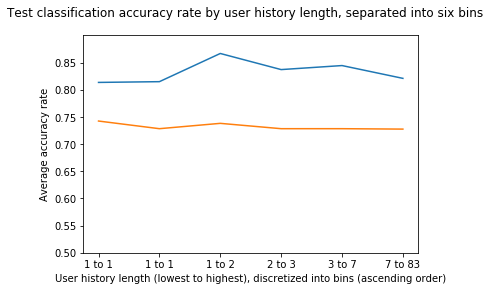

starting ********************************* 1
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.24060150375939848
R2 score for bin 2 = -0.10254083484573528
R2 score for bin 3 = -0.18421052631578938
R2 score for bin 4 = -0.1278195488721805
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


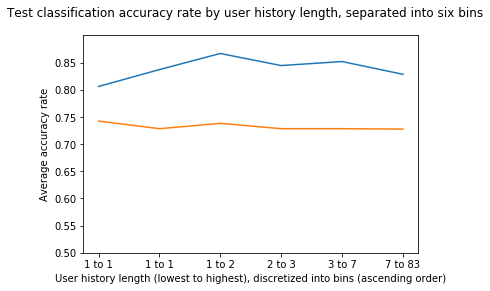

starting ********************************* 2
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.35338345864661647
R2 score for bin 2 = -0.041288566243194325
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


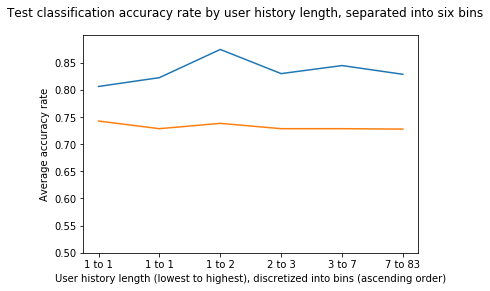

starting ********************************* 3
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7327586206896557
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


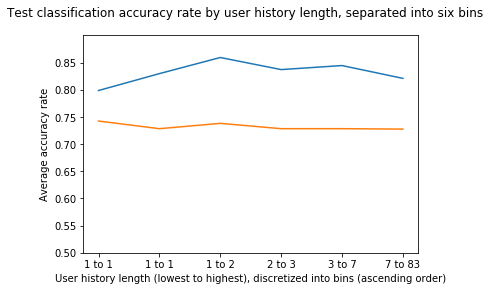

starting ********************************* 4
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.2862976406533577
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


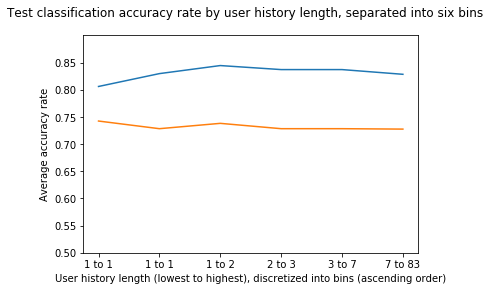

starting ********************************* 5
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6044061302681996
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.2862976406533577
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


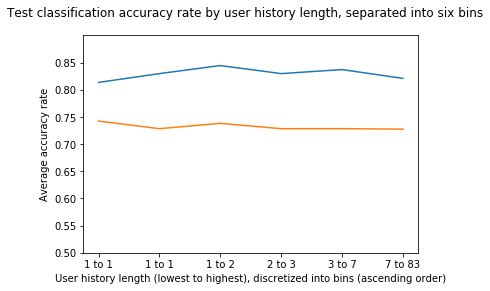

starting ********************************* 6
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.35338345864661647
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


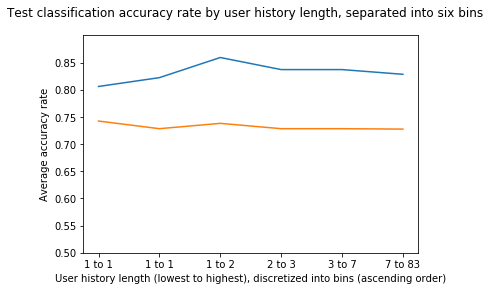

starting ********************************* 7
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7969348659003836
R2 score for bin 1 = -0.18421052631578938
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.18421052631578938
R2 score for bin 4 = -0.1278195488721805
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


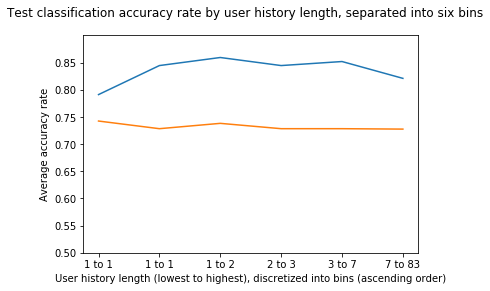

starting ********************************* 8
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7327586206896557
R2 score for bin 1 = -0.24060150375939848
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


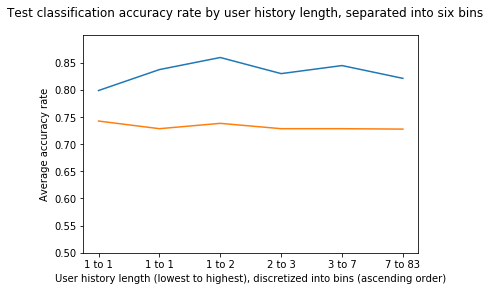

starting ********************************* 9
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.18421052631578938
R2 score for bin 4 = -0.1278195488721805
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


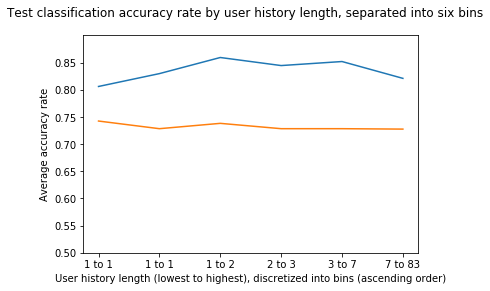

starting ********************************* 10
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.35338345864661647
R2 score for bin 2 = -0.041288566243194325
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.4117151285292875
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


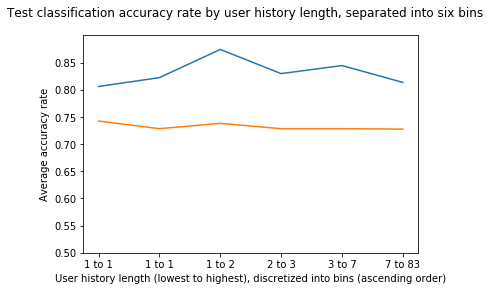

starting ********************************* 11
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7327586206896557
R2 score for bin 1 = -0.35338345864661647
R2 score for bin 2 = -0.22504537205081698
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


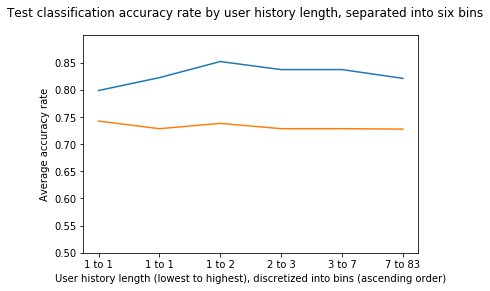

starting ********************************* 12
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6044061302681996
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


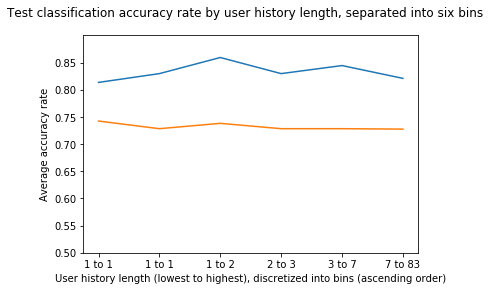

starting ********************************* 13
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.35338345864661647
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


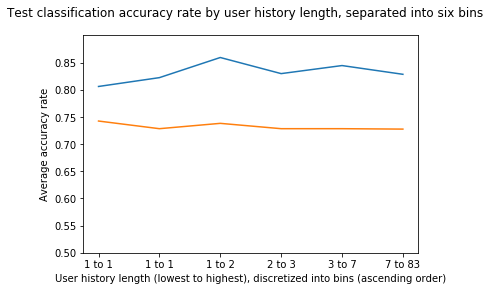

starting ********************************* 14
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.40977443609022557
R2 score for bin 2 = -0.2862976406533577
R2 score for bin 3 = -0.35338345864661647
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


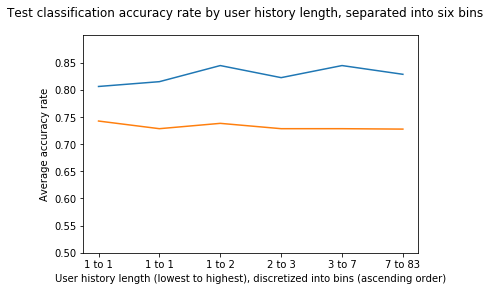

starting ********************************* 15
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.5402298850574716
R2 score for bin 1 = -0.35338345864661647
R2 score for bin 2 = -0.2862976406533577
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


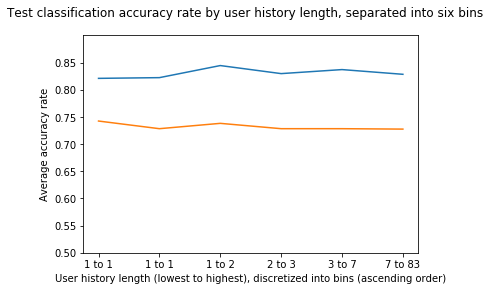

starting ********************************* 16
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6044061302681996
R2 score for bin 1 = -0.40977443609022557
R2 score for bin 2 = -0.22504537205081698
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


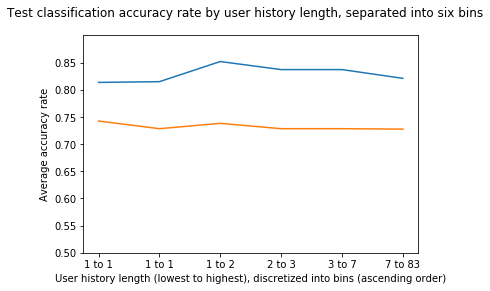

starting ********************************* 17
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6044061302681996
R2 score for bin 1 = -0.24060150375939848
R2 score for bin 2 = -0.22504537205081698
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


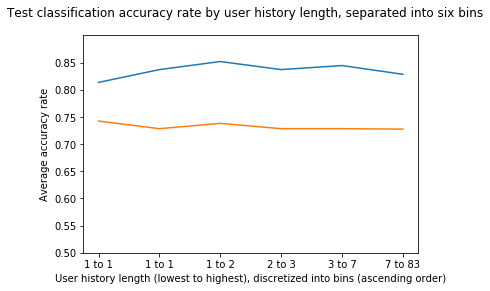

starting ********************************* 18
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7969348659003836
R2 score for bin 1 = -0.24060150375939848
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.1278195488721805
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


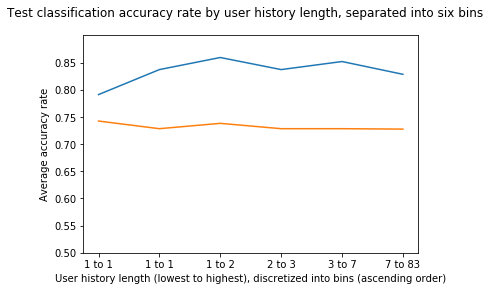

starting ********************************* 19
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6044061302681996
R2 score for bin 1 = -0.18421052631578938
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.18421052631578938
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


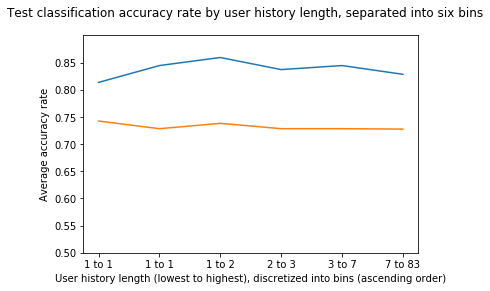

starting ********************************* 20
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7969348659003836
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.22504537205081698
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.1278195488721805
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


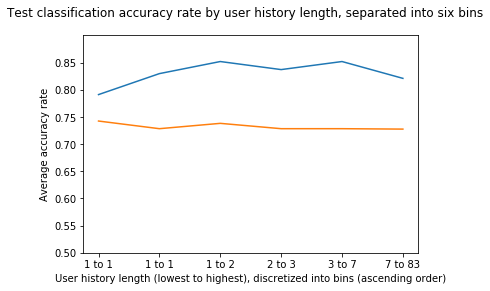

starting ********************************* 21
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7969348659003836
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.22504537205081698
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.1278195488721805
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


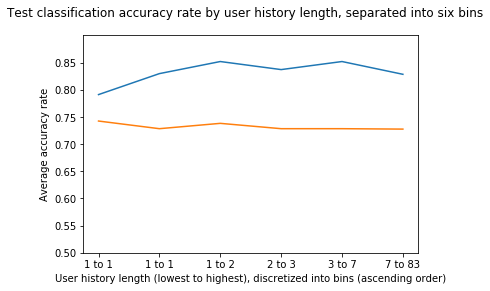

starting ********************************* 22
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.24060150375939848
R2 score for bin 2 = -0.16379310344827602
R2 score for bin 3 = -0.29699248120300736
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


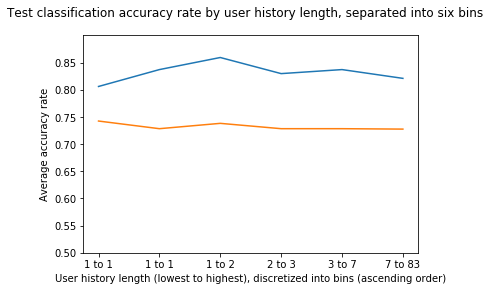

starting ********************************* 23
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.6685823754789275
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.22504537205081698
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.1278195488721805
R2 score for bin 5 = -0.29877791824694455
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


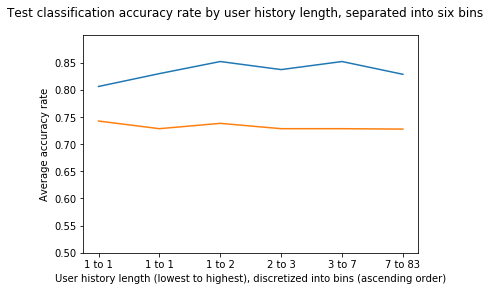

starting ********************************* 24
epoch: 0 learning rate: [0.012299062522117071]
R2 score for bin 0 = -0.7327586206896557
R2 score for bin 1 = -0.29699248120300736
R2 score for bin 2 = -0.22504537205081698
R2 score for bin 3 = -0.24060150375939848
R2 score for bin 4 = -0.24060150375939848
R2 score for bin 5 = -0.35524652338811613
True proportion of + scores in bin 0 = 0.8656716417910447
True proportion of + scores in bin 1 = 0.8444444444444444
True proportion of + scores in bin 2 = 0.8592592592592593
True proportion of + scores in bin 3 = 0.8444444444444444
True proportion of + scores in bin 4 = 0.8444444444444444
True proportion of + scores in bin 5 = 0.8432835820895522


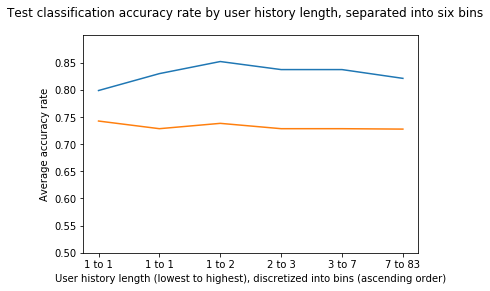

In [5]:

acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test)

Acc: 0.8322772277227724
AUC: 0.7739908814224021
F1: 0.904648128301315
Precision: 0.8755273749807196
Recall: 0.9357787481804948


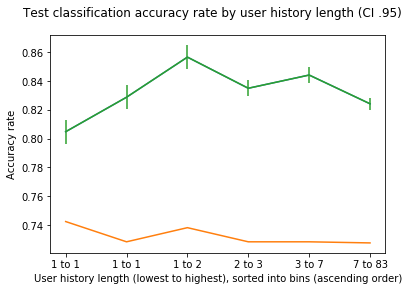

In [6]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [7]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [8]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))

        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'history_baseline_results.npy', results)
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [9]:
# retieve test data history sequence lengths from LSTM data
X_hist_len_test = np.load(NPY_INPUT_DIR + 'full_hist_lens_test.npy')

# load features
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')
 
y_train = np.load(NPY_INPUT_DIR + 'y_train.npy')
y_test = np.load(NPY_INPUT_DIR + 'y_test.npy')

X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')

y_train_tfidf = np.load(TFIDF_DIR + 'trainClassifications.npy')
y_test_tfidf = np.load(TFIDF_DIR + 'testClassifications.npy')


# Normalized

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()


# TODO FIX NAMES!           
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)


epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.528
[1,   400] loss: 0.402
[1,   600] loss: 0.368
[1,   800] loss: 0.345
R2 score for bin 0 = -0.41052631578947407
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


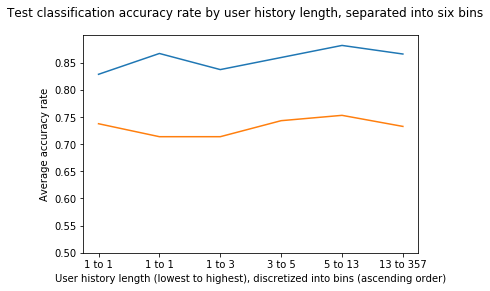

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.530
[1,   400] loss: 0.378
[1,   600] loss: 0.388
[1,   800] loss: 0.333
R2 score for bin 0 = -0.41052631578947407
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


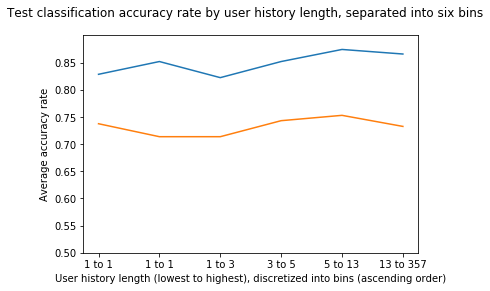

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.509
[1,   400] loss: 0.405
[1,   600] loss: 0.360
[1,   800] loss: 0.332
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.06355042016806745
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


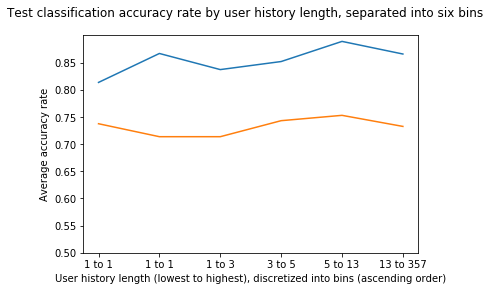

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.515
[1,   400] loss: 0.380
[1,   600] loss: 0.353
[1,   800] loss: 0.370
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


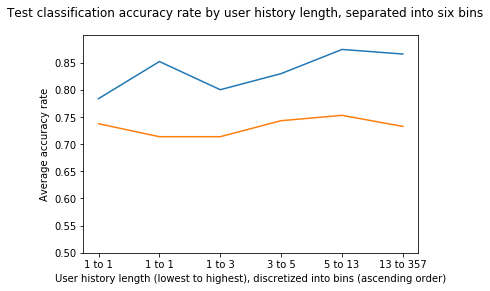

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.531
[1,   400] loss: 0.390
[1,   600] loss: 0.359
[1,   800] loss: 0.357
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


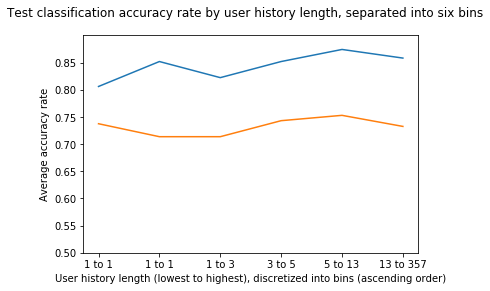

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.525
[1,   400] loss: 0.387
[1,   600] loss: 0.339
[1,   800] loss: 0.378
R2 score for bin 0 = -0.3491990846681925
R2 score for bin 1 = 0.23986486486486458
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


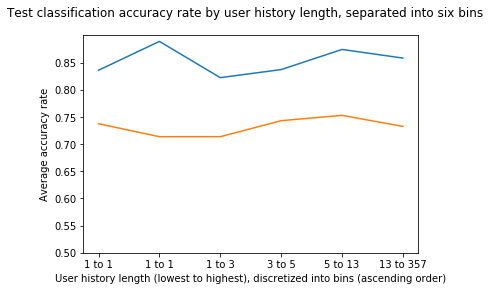

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.505
[1,   400] loss: 0.388
[1,   600] loss: 0.364
[1,   800] loss: 0.344
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


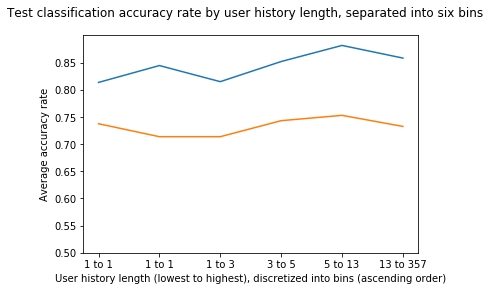

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.526
[1,   400] loss: 0.413
[1,   600] loss: 0.374
[1,   800] loss: 0.334
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


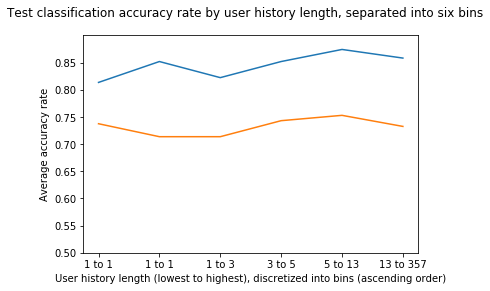

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.523
[1,   400] loss: 0.395
[1,   600] loss: 0.370
[1,   800] loss: 0.337
R2 score for bin 0 = -0.41052631578947407
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.06418918918918903
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


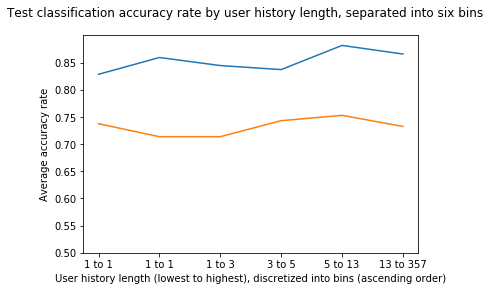

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.521
[1,   400] loss: 0.410
[1,   600] loss: 0.345
[1,   800] loss: 0.346
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = 0.18918918918918892
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.06355042016806745
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


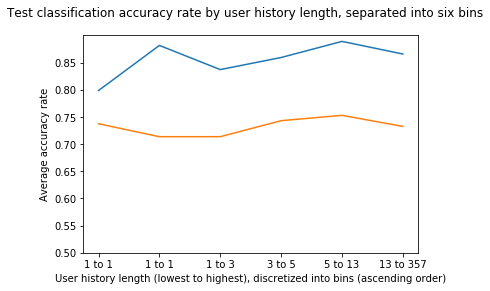

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.529
[1,   400] loss: 0.387
[1,   600] loss: 0.368
[1,   800] loss: 0.343
R2 score for bin 0 = -0.8398169336384442
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


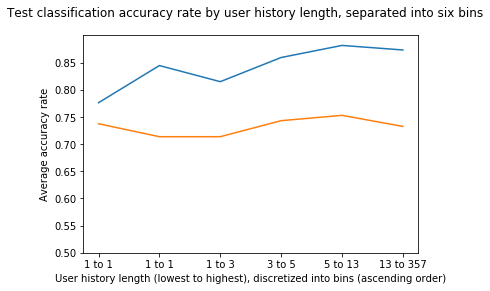

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.508
[1,   400] loss: 0.406
[1,   600] loss: 0.370
[1,   800] loss: 0.335
R2 score for bin 0 = -0.41052631578947407
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.06355042016806745
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


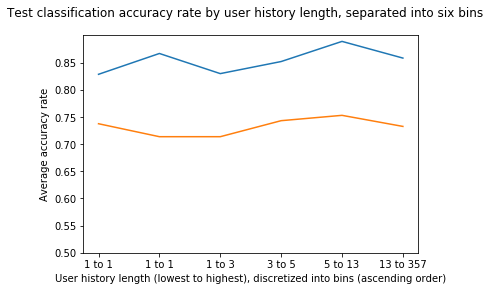

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.537
[1,   400] loss: 0.400
[1,   600] loss: 0.347
[1,   800] loss: 0.342
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = 0.23986486486486458
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


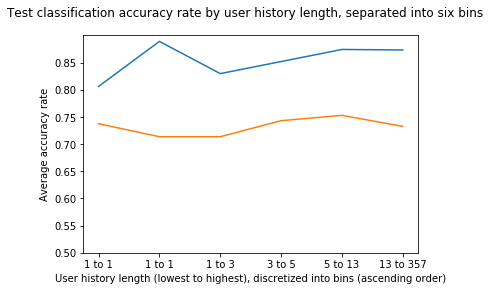

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.500
[1,   400] loss: 0.400
[1,   600] loss: 0.369
[1,   800] loss: 0.353
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = 0.18918918918918892
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


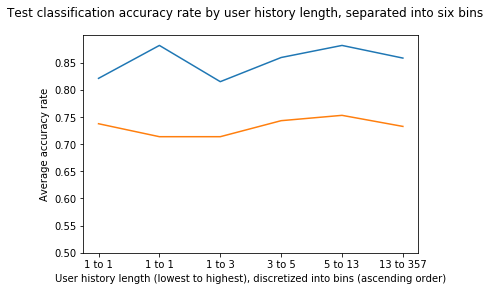

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.534
[1,   400] loss: 0.411
[1,   600] loss: 0.342
[1,   800] loss: 0.335
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


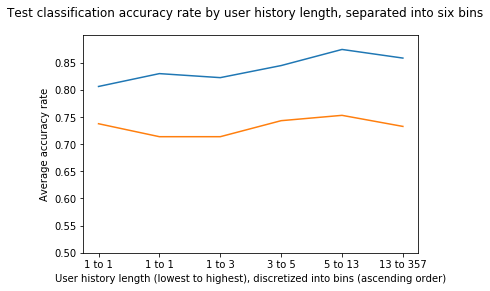

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.516
[1,   400] loss: 0.394
[1,   600] loss: 0.345
[1,   800] loss: 0.372
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.06355042016806745
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


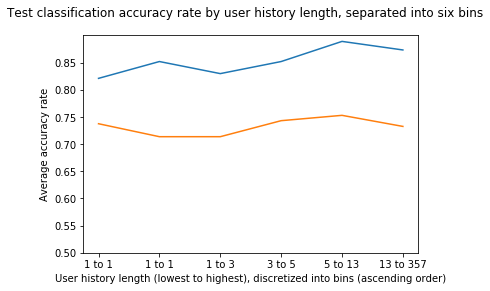

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.520
[1,   400] loss: 0.389
[1,   600] loss: 0.363
[1,   800] loss: 0.341
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


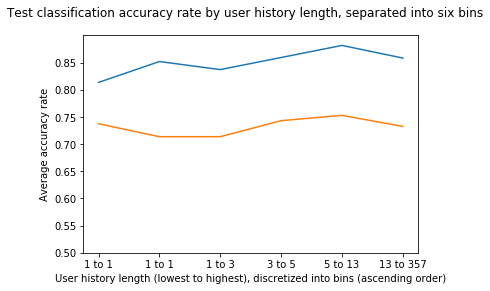

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.523
[1,   400] loss: 0.388
[1,   600] loss: 0.355
[1,   800] loss: 0.349
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.06355042016806745
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


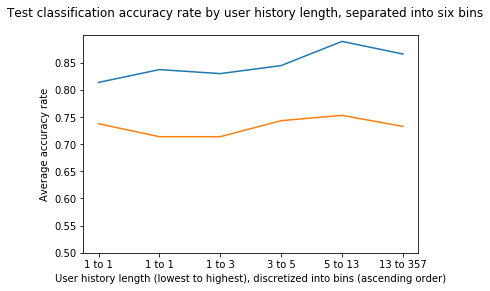

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.534
[1,   400] loss: 0.379
[1,   600] loss: 0.373
[1,   800] loss: 0.360
R2 score for bin 0 = -0.8398169336384442
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


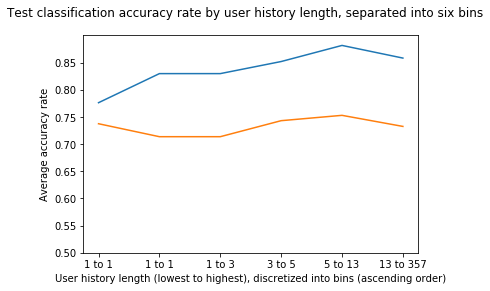

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.547
[1,   400] loss: 0.373
[1,   600] loss: 0.357
[1,   800] loss: 0.358
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


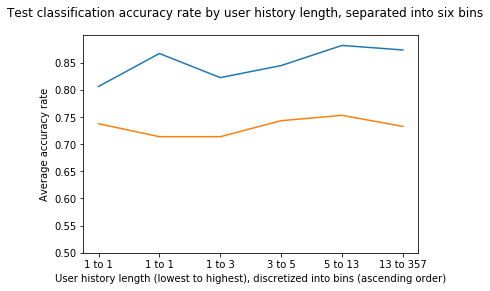

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.529
[1,   400] loss: 0.399
[1,   600] loss: 0.363
[1,   800] loss: 0.345
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = -0.16554054054054101
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


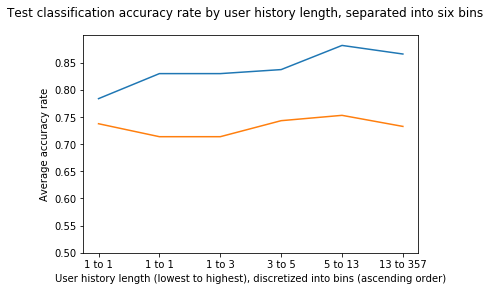

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.531
[1,   400] loss: 0.386
[1,   600] loss: 0.351
[1,   800] loss: 0.348
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


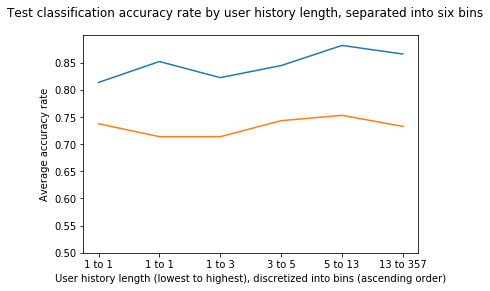

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.534
[1,   400] loss: 0.402
[1,   600] loss: 0.346
[1,   800] loss: 0.351
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


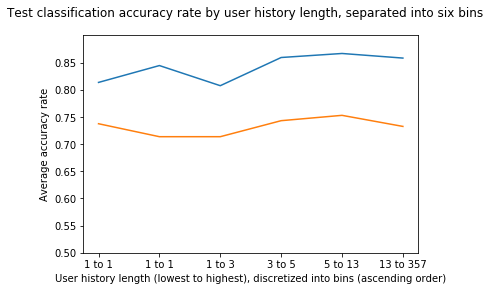

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.536
[1,   400] loss: 0.405
[1,   600] loss: 0.342
[1,   800] loss: 0.337
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.6025641025641024
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


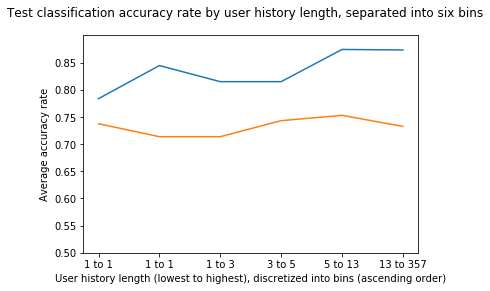

epoch: 0 learning rate: [0.009853003325686935]
[1,   200] loss: 0.526
[1,   400] loss: 0.420
[1,   600] loss: 0.340
[1,   800] loss: 0.353
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = -0.11486486486486513
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.5384615384615383
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + scores in bin 3 = 0.8666666666666667
True proportion of + scores in bin 4 = 0.8814814814814815
True proportion of + scores in bin 5 = 0.8507462686567164


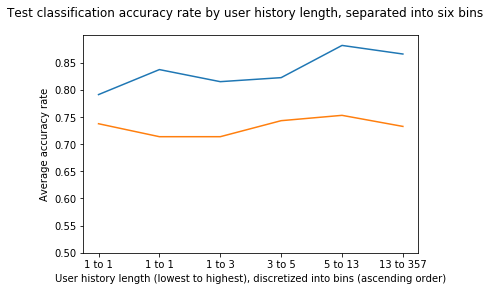

In [10]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.8464356435643563
AUC: 0.7842756264510929
F1: 0.9145402133821213
Precision: 0.8678719060324553
Recall: 0.9666375545851529


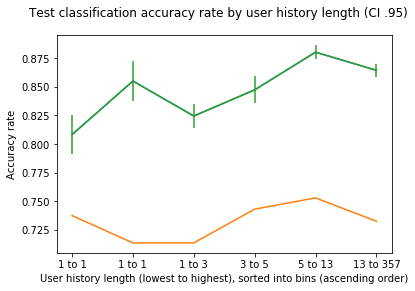

In [11]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [12]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        all_results.append([acc, auc, f1, precision, recall])
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)

    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'nohistory_baseline_results.npy', results)
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [13]:
# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm),
                        axis = 1)

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.764
[1,   400] loss: 0.653
[1,   600] loss: 0.583
[1,   800] loss: 0.706
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.382
[2,   400] loss: 0.359
[2,   600] loss: 0.310
[2,   800] loss: 0.370
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.292
[3,   400] loss: 0.326
[3,   600] loss: 0.309
[3,   800] loss: 0.327
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.304
[4,   400] loss: 0.301
[4,   600] loss: 0.334
[4,   800] loss: 0.308
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion o

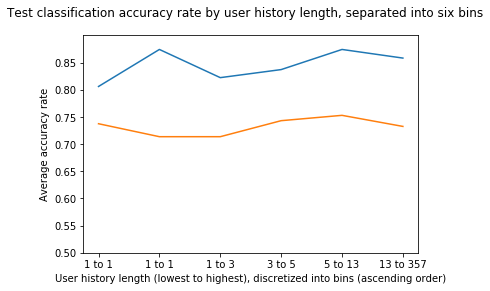

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.762
[1,   400] loss: 0.644
[1,   600] loss: 0.759
[1,   800] loss: 0.696
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.368
[2,   400] loss: 0.353
[2,   600] loss: 0.347
[2,   800] loss: 0.341
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.318
[3,   400] loss: 0.330
[3,   600] loss: 0.304
[3,   800] loss: 0.321
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.329
[4,   400] loss: 0.330
[4,   600] loss: 0.307
[4,   800] loss: 0.286
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.5384615384615383
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of + 

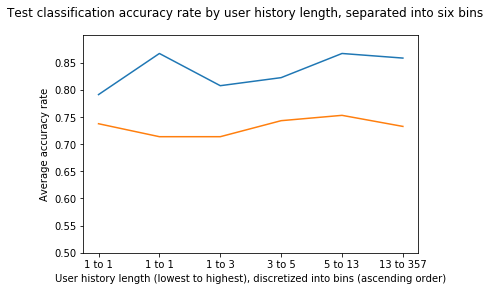

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.642
[1,   400] loss: 0.801
[1,   600] loss: 0.778
[1,   800] loss: 0.579
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.365
[2,   400] loss: 0.320
[2,   600] loss: 0.327
[2,   800] loss: 0.350
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.322
[3,   400] loss: 0.332
[3,   600] loss: 0.304
[3,   800] loss: 0.304
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.312
[4,   400] loss: 0.308
[4,   600] loss: 0.326
[4,   800] loss: 0.299
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of

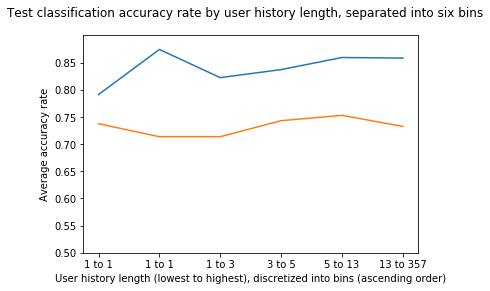

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.826
[1,   400] loss: 0.686
[1,   600] loss: 0.620
[1,   800] loss: 0.577
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.346
[2,   400] loss: 0.342
[2,   600] loss: 0.360
[2,   800] loss: 0.322
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.302
[3,   400] loss: 0.321
[3,   600] loss: 0.307
[3,   800] loss: 0.324
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.295
[4,   400] loss: 0.318
[4,   600] loss: 0.325
[4,   800] loss: 0.296
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of

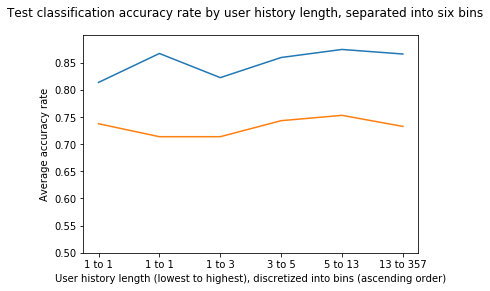

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.916
[1,   400] loss: 0.723
[1,   600] loss: 0.570
[1,   800] loss: 0.571
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.347
[2,   400] loss: 0.340
[2,   600] loss: 0.351
[2,   800] loss: 0.355
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.343
[3,   400] loss: 0.301
[3,   600] loss: 0.341
[3,   800] loss: 0.293
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.299
[4,   400] loss: 0.294
[4,   600] loss: 0.336
[4,   800] loss: 0.324
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion 

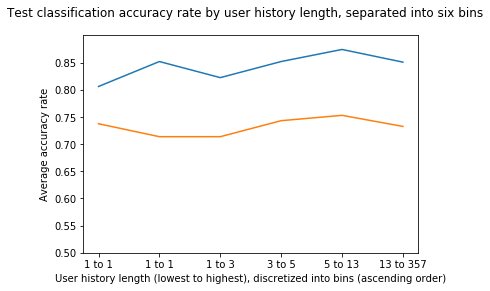

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.713
[1,   400] loss: 0.678
[1,   600] loss: 0.563
[1,   800] loss: 0.560
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.344
[2,   400] loss: 0.357
[2,   600] loss: 0.323
[2,   800] loss: 0.363
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.335
[3,   400] loss: 0.333
[3,   600] loss: 0.300
[3,   800] loss: 0.299
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.300
[4,   400] loss: 0.338
[4,   600] loss: 0.308
[4,   800] loss: 0.299
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = 0.18918918918918892
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of 

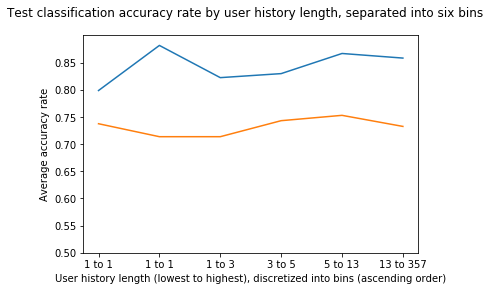

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.747
[1,   400] loss: 0.710
[1,   600] loss: 0.702
[1,   800] loss: 0.524
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.350
[2,   400] loss: 0.361
[2,   600] loss: 0.366
[2,   800] loss: 0.375
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.313
[3,   400] loss: 0.317
[3,   600] loss: 0.336
[3,   800] loss: 0.314
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.320
[4,   400] loss: 0.304
[4,   600] loss: 0.328
[4,   800] loss: 0.307
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of

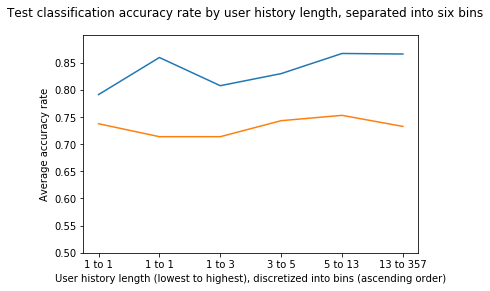

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.792
[1,   400] loss: 0.657
[1,   600] loss: 0.607
[1,   800] loss: 0.548
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.327
[2,   400] loss: 0.340
[2,   600] loss: 0.349
[2,   800] loss: 0.367
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.291
[3,   400] loss: 0.309
[3,   600] loss: 0.326
[3,   800] loss: 0.335
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.308
[4,   400] loss: 0.293
[4,   600] loss: 0.323
[4,   800] loss: 0.316
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of

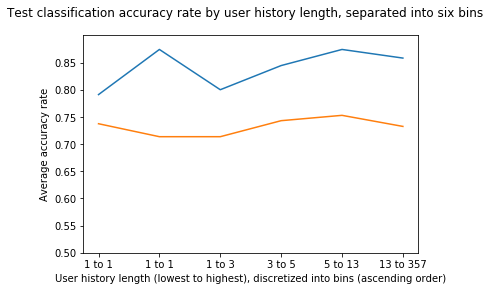

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.841
[1,   400] loss: 0.694
[1,   600] loss: 0.584
[1,   800] loss: 0.646
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.339
[2,   400] loss: 0.379
[2,   600] loss: 0.367
[2,   800] loss: 0.355
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.325
[3,   400] loss: 0.290
[3,   600] loss: 0.312
[3,   800] loss: 0.351
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.287
[4,   400] loss: 0.351
[4,   600] loss: 0.292
[4,   800] loss: 0.314
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of

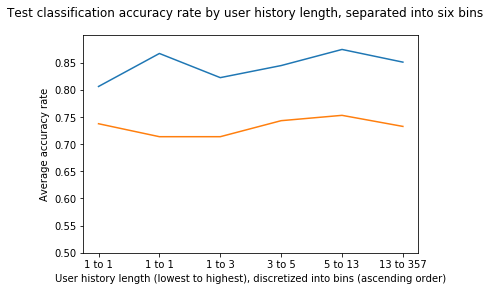

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.770
[1,   400] loss: 0.761
[1,   600] loss: 0.647
[1,   800] loss: 0.633
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.356
[2,   400] loss: 0.336
[2,   600] loss: 0.382
[2,   800] loss: 0.328
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.332
[3,   400] loss: 0.277
[3,   600] loss: 0.327
[3,   800] loss: 0.339
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.317
[4,   400] loss: 0.363
[4,   600] loss: 0.280
[4,   800] loss: 0.292
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of +

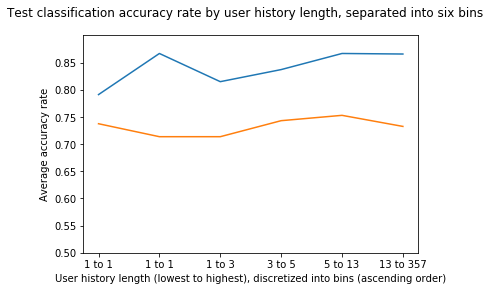

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.815
[1,   400] loss: 0.821
[1,   600] loss: 0.598
[1,   800] loss: 0.516
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.328
[2,   400] loss: 0.348
[2,   600] loss: 0.350
[2,   800] loss: 0.365
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.303
[3,   400] loss: 0.330
[3,   600] loss: 0.322
[3,   800] loss: 0.329
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.348
[4,   400] loss: 0.313
[4,   600] loss: 0.282
[4,   800] loss: 0.307
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.013513513513513375
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.17543859649122862
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion 

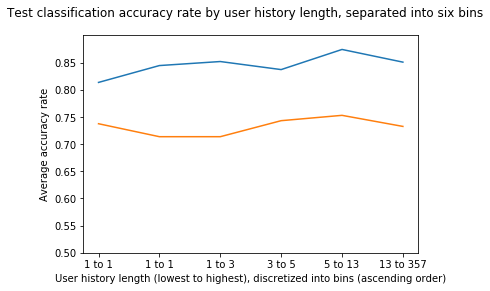

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.667
[1,   400] loss: 0.634
[1,   600] loss: 0.647
[1,   800] loss: 0.612
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.341
[2,   400] loss: 0.313
[2,   600] loss: 0.396
[2,   800] loss: 0.349
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.329
[3,   400] loss: 0.297
[3,   600] loss: 0.331
[3,   800] loss: 0.328
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.326
[4,   400] loss: 0.299
[4,   600] loss: 0.294
[4,   800] loss: 0.332
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.13445378151260523
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion o

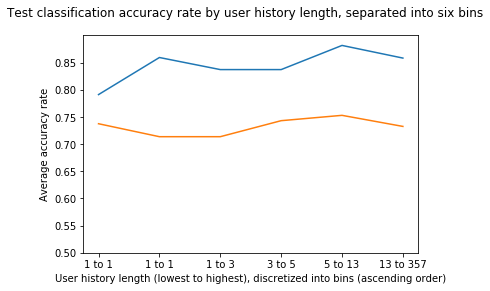

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.682
[1,   400] loss: 0.740
[1,   600] loss: 0.531
[1,   800] loss: 0.594
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.384
[2,   400] loss: 0.318
[2,   600] loss: 0.364
[2,   800] loss: 0.384
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.347
[3,   400] loss: 0.302
[3,   600] loss: 0.322
[3,   800] loss: 0.317
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.306
[4,   400] loss: 0.325
[4,   600] loss: 0.311
[4,   800] loss: 0.324
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.31756756756756754
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of

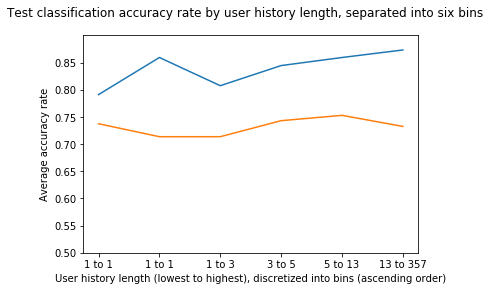

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.735
[1,   400] loss: 0.769
[1,   600] loss: 0.542
[1,   800] loss: 0.739
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.381
[2,   400] loss: 0.327
[2,   600] loss: 0.355
[2,   800] loss: 0.348
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.342
[3,   400] loss: 0.332
[3,   600] loss: 0.315
[3,   800] loss: 0.298
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.318
[4,   400] loss: 0.328
[4,   600] loss: 0.263
[4,   800] loss: 0.350
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = -0.01351351351351382
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = 0.000877192982455699
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion o

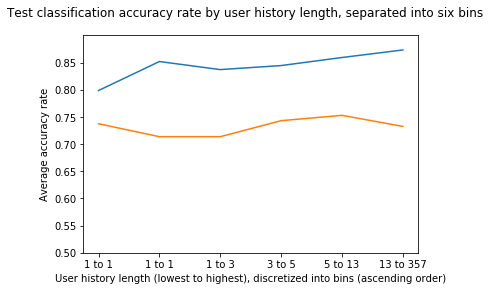

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.741
[1,   400] loss: 0.665
[1,   600] loss: 0.701
[1,   800] loss: 0.547
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.346
[2,   400] loss: 0.367
[2,   600] loss: 0.337
[2,   800] loss: 0.356
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.313
[3,   400] loss: 0.322
[3,   600] loss: 0.314
[3,   800] loss: 0.321
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.291
[4,   400] loss: 0.333
[4,   600] loss: 0.324
[4,   800] loss: 0.302
R2 score for bin 0 = -0.9011441647597258
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.3682432432432432
R2 score for bin 3 = -0.15384615384615374
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of +

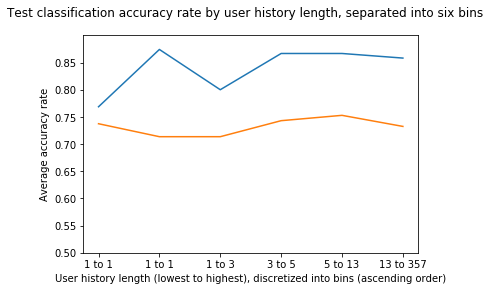

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.784
[1,   400] loss: 0.630
[1,   600] loss: 0.661
[1,   800] loss: 0.490
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.375
[2,   400] loss: 0.371
[2,   600] loss: 0.338
[2,   800] loss: 0.359
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.350
[3,   400] loss: 0.305
[3,   600] loss: 0.316
[3,   800] loss: 0.297
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.318
[4,   400] loss: 0.307
[4,   600] loss: 0.321
[4,   800] loss: 0.305
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of 

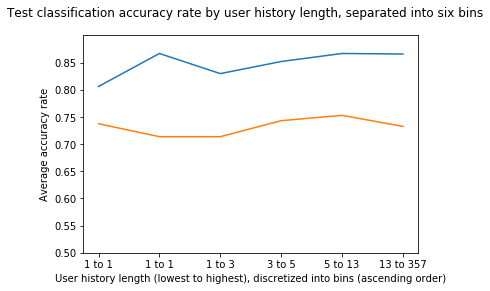

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.757
[1,   400] loss: 0.666
[1,   600] loss: 0.702
[1,   800] loss: 0.568
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.359
[2,   400] loss: 0.383
[2,   600] loss: 0.304
[2,   800] loss: 0.357
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.307
[3,   400] loss: 0.296
[3,   600] loss: 0.339
[3,   800] loss: 0.336
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.317
[4,   400] loss: 0.303
[4,   600] loss: 0.307
[4,   800] loss: 0.332
R2 score for bin 0 = -0.533180778032037
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.11486486486486491
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of 

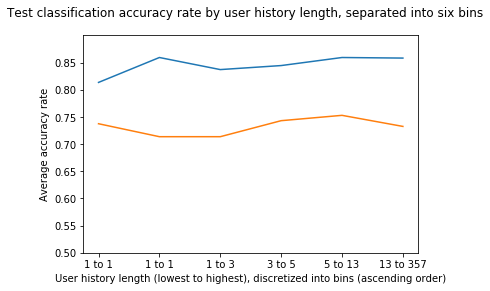

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.707
[1,   400] loss: 0.713
[1,   600] loss: 0.577
[1,   800] loss: 0.609
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.378
[2,   400] loss: 0.335
[2,   600] loss: 0.357
[2,   800] loss: 0.323
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.291
[3,   400] loss: 0.303
[3,   600] loss: 0.344
[3,   800] loss: 0.335
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.325
[4,   400] loss: 0.309
[4,   600] loss: 0.312
[4,   800] loss: 0.302
R2 score for bin 0 = -0.47185354691075543
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.16554054054054057
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion 

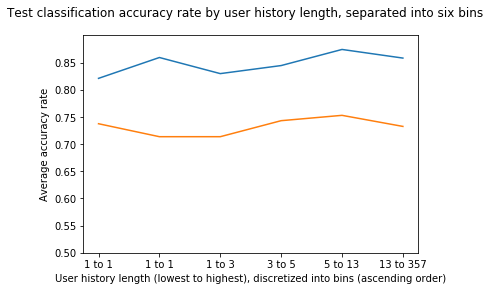

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.707
[1,   400] loss: 0.731
[1,   600] loss: 0.611
[1,   800] loss: 0.585
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.336
[2,   400] loss: 0.361
[2,   600] loss: 0.318
[2,   800] loss: 0.370
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.319
[3,   400] loss: 0.300
[3,   600] loss: 0.342
[3,   800] loss: 0.308
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.285
[4,   400] loss: 0.376
[4,   600] loss: 0.306
[4,   800] loss: 0.276
R2 score for bin 0 = -0.5945080091533184
R2 score for bin 1 = -0.06418918918918948
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.28205128205128194
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion

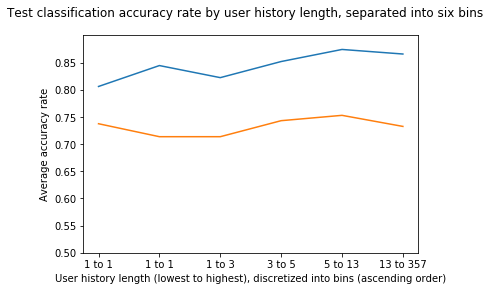

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.765
[1,   400] loss: 0.646
[1,   600] loss: 0.576
[1,   800] loss: 0.598
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.396
[2,   400] loss: 0.351
[2,   600] loss: 0.316
[2,   800] loss: 0.339
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.343
[3,   400] loss: 0.325
[3,   600] loss: 0.298
[3,   800] loss: 0.299
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.286
[4,   400] loss: 0.296
[4,   600] loss: 0.338
[4,   800] loss: 0.331
R2 score for bin 0 = -0.9624713958810074
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.21794871794871784
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion o

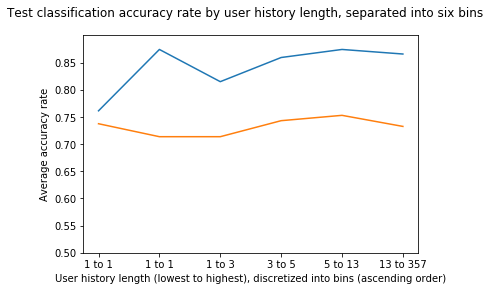

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.676
[1,   400] loss: 0.741
[1,   600] loss: 0.580
[1,   800] loss: 0.534
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.328
[2,   400] loss: 0.334
[2,   600] loss: 0.365
[2,   800] loss: 0.349
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.286
[3,   400] loss: 0.331
[3,   600] loss: 0.326
[3,   800] loss: 0.322
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.358
[4,   400] loss: 0.273
[4,   600] loss: 0.300
[4,   800] loss: 0.313
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = 0.0878378378378376
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion o

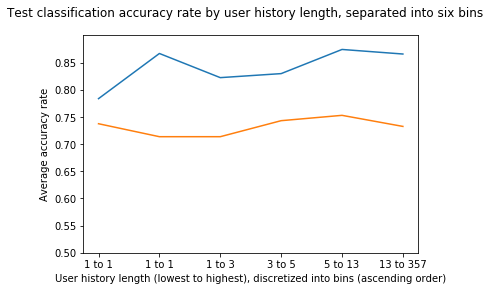

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.688
[1,   400] loss: 0.674
[1,   600] loss: 0.659
[1,   800] loss: 0.607
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.331
[2,   400] loss: 0.358
[2,   600] loss: 0.342
[2,   800] loss: 0.366
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.339
[3,   400] loss: 0.316
[3,   600] loss: 0.299
[3,   800] loss: 0.309
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.313
[4,   400] loss: 0.312
[4,   600] loss: 0.302
[4,   800] loss: 0.318
R2 score for bin 0 = -0.7784897025171629
R2 score for bin 1 = 0.13851351351351326
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.41025641025641013
R2 score for bin 4 = -0.3471638655462188
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of

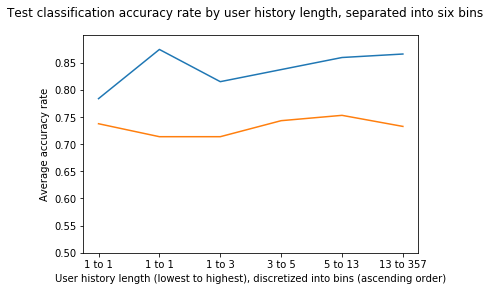

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.826
[1,   400] loss: 0.567
[1,   600] loss: 0.717
[1,   800] loss: 0.575
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.326
[2,   400] loss: 0.354
[2,   600] loss: 0.378
[2,   800] loss: 0.366
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.295
[3,   400] loss: 0.344
[3,   600] loss: 0.317
[3,   800] loss: 0.317
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.338
[4,   400] loss: 0.296
[4,   600] loss: 0.309
[4,   800] loss: 0.318
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of +

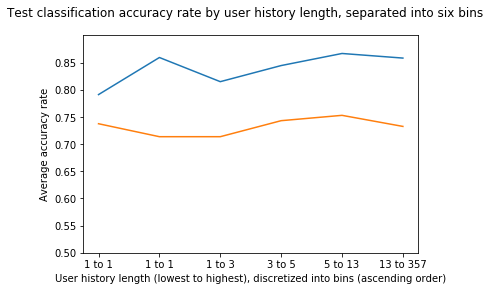

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.644
[1,   400] loss: 0.801
[1,   600] loss: 0.717
[1,   800] loss: 0.601
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.344
[2,   400] loss: 0.351
[2,   600] loss: 0.333
[2,   800] loss: 0.363
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.323
[3,   400] loss: 0.309
[3,   600] loss: 0.315
[3,   800] loss: 0.310
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.294
[4,   400] loss: 0.327
[4,   600] loss: 0.313
[4,   800] loss: 0.309
R2 score for bin 0 = -0.6558352402745999
R2 score for bin 1 = 0.18918918918918892
R2 score for bin 2 = -0.21621621621621623
R2 score for bin 3 = -0.47435897435897423
R2 score for bin 4 = -0.20535714285714302
R2 score for bin 5 = -0.11666666666666714
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion o

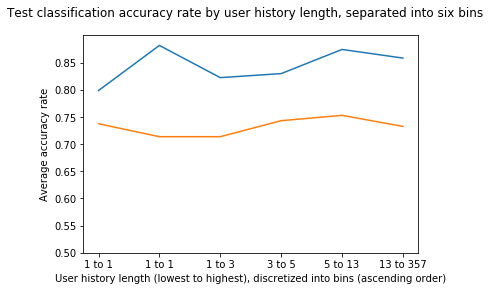

epoch: 0 learning rate: [0.058529866163076795]
[1,   200] loss: 0.865
[1,   400] loss: 0.596
[1,   600] loss: 0.538
[1,   800] loss: 0.545
epoch: 1 learning rate: [0.009623453756134437]
[2,   200] loss: 0.340
[2,   400] loss: 0.332
[2,   600] loss: 0.394
[2,   800] loss: 0.348
epoch: 2 learning rate: [0.0015822838538264248]
[3,   200] loss: 0.350
[3,   400] loss: 0.327
[3,   600] loss: 0.275
[3,   800] loss: 0.321
epoch: 3 learning rate: [0.00026015838570262546]
[4,   200] loss: 0.318
[4,   400] loss: 0.305
[4,   600] loss: 0.306
[4,   800] loss: 0.301
R2 score for bin 0 = -0.7171624713958813
R2 score for bin 1 = 0.03716216216216184
R2 score for bin 2 = -0.2668918918918919
R2 score for bin 3 = -0.34615384615384603
R2 score for bin 4 = -0.276260504201681
R2 score for bin 5 = -0.057894736842105665
True proportion of + scores in bin 0 = 0.8582089552238806
True proportion of + scores in bin 1 = 0.8222222222222222
True proportion of + scores in bin 2 = 0.8222222222222222
True proportion of 

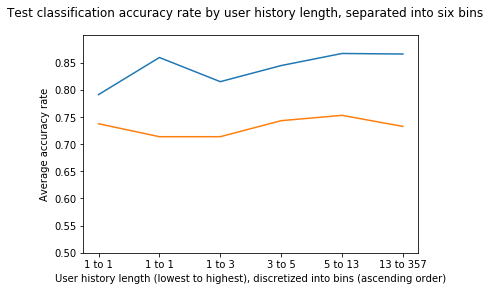

In [14]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.8423762376237625
AUC: 0.7801135611774755
F1: 0.9113999166481125
Precision: 0.8728159617001989
Recall: 0.9536535662299854


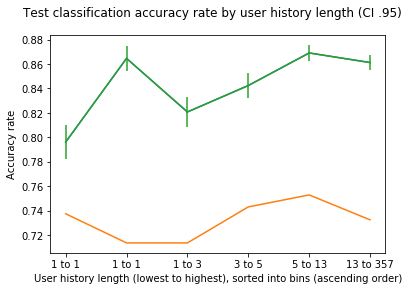

In [15]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)



